In [ ]:
'''
q-learner
    -policy
    -value function
    -update()
    -move()
    
portfolio
    -cash
    -assets
    -orderHistory
        -orders[{time, asset, action, amount, value}]
        -show()
    -show()

Notes
    -sharpe ratio = risk/reward
    -volatility = standard deviation
    -momentum = price change over time = (data[n] / data[n-t]) - 1
    -bollinger bands
    

Dyna Q:
http://www-anw.cs.umass.edu/~barto/courses/cs687/Chapter%209.pdf
'''


In [46]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Read data
filePath = 'data/spy_5yrs.csv'
data = pd.read_csv(filePath,header=0,index_col='date')

# Remove first row (bad data)
data = data.iloc[1:]

# Sort data by index (ascending)
data = data.loc[sorted(data.index)]

# Take only the daily close data and normalize it
data = pd.DataFrame(data['close'])
data['close'] = data['close']/data['close'][0]

In [13]:
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(center=False, window=window).mean()


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return values.rolling(center=False, window=window).std()


def get_bollinger_bands(rm, rstd, b=2):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + b*rstd
    lower_band = rm - b*rstd
    return upper_band, lower_band

def get_momentum(values, window):
    momentum = values - values.shift(window)
    return momentum

In [47]:
data.head()

,close
date,
2012/12/07,1.000000
2012/12/10,1.000407
2012/12/11,1.007197
2012/12/12,1.007689
2012/12/13,1.001510


In [48]:
# Define state features
window_mean = 20
window_std = 20

data['rm'] = get_rolling_mean(data['close'], window_mean)
data['rstd'] = get_rolling_std(data['close'], window_std)
data['ubb_1.5'], data['lbb_1.5'] = get_bollinger_bands(data['rm'],data['rstd'],b=1.5)
data['ubb_2.0'], data['lbb_2.0'] = get_bollinger_bands(data['rm'],data['rstd'],b=2)
data['ubb_2.5'], data['lbb_2.5'] = get_bollinger_bands(data['rm'],data['rstd'],b=2.5)
data['mom_2'] = get_momentum(data['close'], window=2)
data['rstd_5'] = get_rolling_std(data['close'], window_vol)

In [49]:
data

,close,rm,rstd,ubb_1.5,lbb_1.5,ubb_2.0,lbb_2.0,ubb_2.5,lbb_2.5,mom_2,rstd_5
date,,,,,,,,,,,
2012/12/07,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012/12/10,1.000407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012/12/11,1.007197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007197,NaN
2012/12/12,1.007689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007282,NaN
2012/12/13,1.001510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005688,0.003771
2012/12/14,0.997824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009865,0.004339
2012/12/17,1.009514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008005,0.004894
2012/12/18,1.020749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022925,0.008791
2012/12/19,1.013166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003651,0.009161


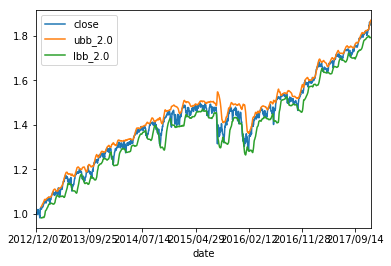

In [50]:
# Plot data
data[['close','ubb_2.0','lbb_2.0']].plot()
plt.show()

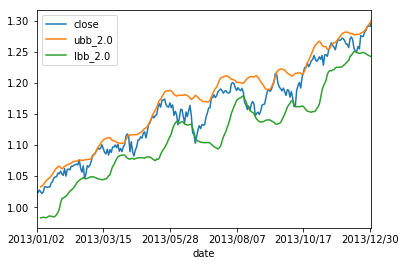

In [51]:
# Plot first 200 data points
data.loc['2013-01-01':'2014-01-01'][['close','ubb_2.0','lbb_2.0']].plot()

In [66]:
# Transform data to have states with fewer posible values
state_df = pd.DataFrame(data={
    'above_ubb_1.5': data['close'] > data['ubb_1.5'],
    'above_ubb_2.0': data['close'] > data['ubb_2.0'],
    'above_ubb_2.5': data['close'] > data['ubb_2.5'],
    'below_lbb_1.5': data['close'] > data['lbb_1.5'],
    'below_lbb_2.0': data['close'] > data['lbb_2.0'],
    'below_lbb_2.5': data['close'] > data['lbb_2.5'],
    'momentum': pd.Series(['up' if x>0 else 'down' if x<0 else 'same' for x in data['mom_2']],index=data.index)
})

state_df

,above_ubb_1.5,above_ubb_2.0,above_ubb_2.5,below_lbb_1.5,below_lbb_2.0,below_lbb_2.5,momentum
date,,,,,,,
2012/12/07,False,False,False,False,False,False,same
2012/12/10,False,False,False,False,False,False,same
2012/12/11,False,False,False,False,False,False,up
2012/12/12,False,False,False,False,False,False,up
2012/12/13,False,False,False,False,False,False,down
2012/12/14,False,False,False,False,False,False,down
2012/12/17,False,False,False,False,False,False,up
2012/12/18,False,False,False,False,False,False,up
2012/12/19,False,False,False,False,False,False,up


In [ ]:
'''
State: ubb, lbb, close
Action: buy (if cash > 0), sell (if stock > 0), hold
Reward: cummulative portfolio gain
    Reward function: (shares * close) + cash
Discount: .9 (close to 1 to prioritize long-term goals but still force 
    incentive to do something other than hold)

initialize q_table w/ random values
initial state = data in initial date
choose action based on greed or random event

q[s][a] = q[s][a] + alpha[r + g*max_a'(q[s'][a']) - q[s][a]]



'''